In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data read 
words = open('/home/risal/X3s4c5/Makemore/names.txt','r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
# Data components 
def build_dataset(words):
    X, Y= [] , []
    block_size = 3
    
    for w in words:
        context  = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_trn, Y_trn = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_tst, Y_tst = build_dataset(words[n2:])

In [6]:
X_trn.shape, X_dev.shape, X_tst.shape

(torch.Size([182778, 3]), torch.Size([22633, 3]), torch.Size([22735, 3]))

In [7]:
n1, n2

(25626, 28829)

In [ ]:
X.shape, Y.shape, len(words)

In [235]:
# creating the embedding look up table 
C = torch.randn((27,2))

In [236]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [243]:
W1 = torch.rand((6,100))
b1 = torch.randn(100) 

In [244]:
torch.cat([emb[: ,0 , :], emb[: ,1 , :], emb[: ,2 , :]], dim = 1).shape, W1.shape

(torch.Size([228146, 6]), torch.Size([6, 100]))

In [245]:
h = torch.tanh(emb.view((-1,6)) @ W1 + b1)

In [246]:
h.shape

torch.Size([228146, 100])

In [247]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [248]:
counts = logits.exp()
counts.shape

torch.Size([228146, 27])

In [249]:
probs = counts / counts.sum(1, keepdims = True)
probs.shape

torch.Size([228146, 27])

In [251]:
loss = -probs[torch.arange(X.shape[0]), Y].log().mean()

In [252]:
loss

tensor(17.9299)

In [253]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [9]:
# Defining 
X_trn.shape, Y_trn.shape

(torch.Size([182778, 3]), torch.Size([182778]))

In [43]:
g = torch.Generator().manual_seed(123)
C = torch.randn((27,10), generator = g) # embedding lookup table
W1 = torch.randn((30, 150), generator = g)
b1 = torch.randn(150, generator = g)
W2 = torch.randn((150,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [W1, b1, W2, b2]

In [44]:
sum(p.nelement() for p in parameters)

8727

In [45]:
for p in parameters:
    p.requires_grad = True

In [46]:
lre = torch.linspace(-3,0, 1000)
lrs = 10**lre

In [47]:
losses = []
lrt =[]
for i in range(1000):
    # mini batch
    ix = torch.randint(0,X_trn.shape[0], (128,))
    # forward passes 
    emb = C[X_trn[ix]] # [32, 4, 2]
    h = torch.tanh(emb.view((-1,30)) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2 #  [32, 27]
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims = True)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits,  Y_trn[ix]) 

    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params 
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    lrt.append(lre[i])
    losses.append(loss.item())

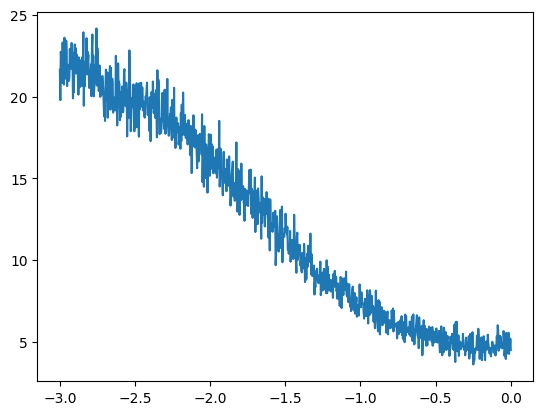

In [48]:
plt.plot(lrt, losses)

In [49]:
losses_train = []
step_i = []

In [61]:
for i in range(10000):
    # mini batch
    ix = torch.randint(0,X_trn.shape[0], (32,))
    # forward passes 
    emb = C[X_trn[ix]] # [32, 4, 2]
    h = torch.tanh(emb.view((-1,30)) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2 #  [32, 27]
    loss = F.cross_entropy(logits,  Y_trn[ix]) 

    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    lr = 0.1 # use initial lr as 0.25 and decay lr as 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats 
    losses_train.append(loss.item())
    step_i.append(step_i)
loss.item()

2.179636240005493

KeyboardInterrupt: 

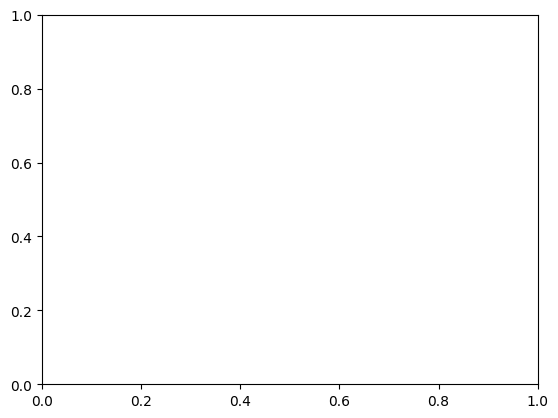

In [68]:
plt.plot(step_i, losses_train)

In [63]:
emb = C[X_dev] # [32, 4, 2]
h = torch.tanh(emb.view((-1,30)) @ W1 + b1)  # [32, 100
logits = h @ W2 + b2 #  [32, 27]
loss = F.cross_entropy(logits,  Y_dev) 
loss

tensor(2.4926, grad_fn=<NllLossBackward0>)

In [64]:
emb = C[X_trn] # [32, 4, 2]
h = torch.tanh(emb.view((-1,30)) @ W1 + b1)  # [32, 100
logits = h @ W2 + b2 #  [32, 27]
loss = F.cross_entropy(logits,  Y_trn) 
loss

tensor(2.1707, grad_fn=<NllLossBackward0>)